In [ ]:
# !pip3 install gpflow==2.2.1

In [2]:
%load_ext autoreload
%autoreload 2

from multiprocessing import Pool, freeze_support
from matplotlib import pyplot as plt
from changepoint_detection import *
from utils import standardize
from datetime import datetime
from functools import partial
from itertools import repeat
from models.losses import *
from ts2vec import TS2Vec
from tqdm import tqdm
from os import walk
import pandas as pd
import numpy as np
import datautils
import torch
import json
import os





# from polygon import RESTClient
# from metafeatures import *

 

USE_KM_HYP_TO_INITIALISE_KC = True

# data_url    = 'https://datahub.io/core/s-and-p-500-companies/datapackage.json'
# f           = open("/Users/abuj/Documents/GitHub/CFT/datasets/sp500_constituents.json")
# data        = json.load(f)
# # len( data['2012/12/31'] )


print ( os.cpu_count() )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
4


In [33]:
BASE_PATH                           = "/home/ec2-user/CFT/datasets/"
stock_data_path_hour                = BASE_PATH + "STOCKS/hour/"
ffd_path_hour                       = BASE_PATH + "META_FEATURES/FFD/hour/"
cpd_path_hour                       = BASE_PATH + "META_FEATURES/CPD/hour/"

stock_data_path_day                 = BASE_PATH + "STOCKS/day/"
ffd_path_day                        = BASE_PATH + "META_FEATURES/FFD/day/"
cpd_path_day                        = BASE_PATH + "META_FEATURES/CPD/day/"

cpd_path_test                       = BASE_PATH + "META_FEATURES/CPD/test/"
cpd_path_test2                      = BASE_PATH + "META_FEATURES/CPD/test2/"

short_cpd_lookback_window_length    = 12
long_cpd_lookback_window_length     = 126

filenames_hour                      = next(walk(stock_data_path_hour), (None, None, []))[2] 
filenames_day                       = next(walk(stock_data_path_day), (None, None, []))[2]  

cols_to_perform_ffd = ['open', 'high', 'low', 'close', 'vwap']

In [5]:
'''Download data from polygon'''

# client = RESTClient("ZV6Xy3SWzsJ2xawzRp0JXlmUbbIHePWF")
# START_DATE  = pd.to_datetime("2012-12-31")
# END_DATE    = pd.to_datetime("2022-10-09")

# with open("/Users/abuj/Documents/GitHub/CFT/datasets/ASSETS_NOT_SUPPORTED_BY_POLYGON", "rb") as fp:
#    ASSETS_NOT_SUPPORTED_BY_POLYGON = pickle.load(fp)

# ASSETS = data['2012/12/31']
# ASSETS = set(ASSETS) - set(ASSETS_NOT_SUPPORTED_BY_POLYGON)
# ASSETS = list( ASSETS )

# aggregates = ['day', 'hour']
# time_delta = {}
# time_delta['day']  = pd.Timedelta(days=1500)
# time_delta['hour'] = pd.Timedelta(hours=800)

# failed_assets = []
# stocks_folder = "/Users/abuj/Documents/GitHub/CFT/datasets/STOCKS/"
# for timeframe in aggregates:
#     for x in tqdm( ASSETS[:] ):
#         if x in ASSETS_NOT_SUPPORTED_BY_POLYGON: continue
#         try:
#             file_path = stocks_folder + timeframe + "/" + x + ".csv"
#             my_file = Path(file_path)
#             if my_file.is_file(): continue
            
#             curr_date = START_DATE
#             aggs = []
#             while curr_date < END_DATE:
#                 until_date = curr_date + time_delta[timeframe]
#                 until_date = min(until_date, END_DATE)
#                 if (until_date - curr_date).days <= 0:
#                     break
#                 # print(curr_date, until_date)
#                 aggs += client.get_aggs(x, 1, timeframe, curr_date.strftime("%Y-%m-%d"), until_date.strftime("%Y-%m-%d"), limit=50000)
#                 curr_date += time_delta[timeframe]

#             df = pd.DataFrame(aggs).drop('otc', axis=1)
#             df.timestamp = pd.to_datetime(df.timestamp, unit='ms', utc=True)
#             df.drop_duplicates(inplace=True)
#             df.set_index('timestamp', inplace=True)

#             df.to_csv(file_path)
#         except:
#             print(x, " failed")
#             failed_assets.append(x)


# li = list( set( failed_assets + ASSETS_NOT_SUPPORTED_BY_POLYGON ) )
# with open("/Users/abuj/Documents/GitHub/CFT/datasets/ASSETS_NOT_SUPPORTED_BY_POLYGON", "wb") as fp:   #Pickling
#    pickle.dump(li, fp)

'''Process FFD data from polygon'''

# for file in tqdm(filenames):
#     try:
#         file_path = ffd_path + "/" + file
#         my_file = Path(file_path)
#         if my_file.is_file(): continue
        
#         df = pd.read_csv( mypath + file , index_col='timestamp')
#         df.index  = pd.to_datetime( df.index )
#         df_ffd = pd.DataFrame(index=df.index)

#         for col in cols_to_perform_ffd:
#             df_ffd[col+"_0.3"]  = get_frac_diff_series(df, col, coef_d=0.3, plot=False)
#             df_ffd[col+"_0.6"]  = get_frac_diff_series(df, col, coef_d=0.6, plot=False)
#         max_nans            = df_ffd.isna().sum().max() + 1
#         df_ffd              = df_ffd[max_nans:]

#         df_ffd.to_csv(file_path)
#     except Exception as e:
#         print(e, file, " failed")

'Process FFD data from polygon'

In [7]:

def prep_data_for_cpd(file, folder_path):

    temp            = pd.read_csv(folder_path + file).set_index('timestamp')[cols_to_perform_ffd]
    temp.index      = pd.to_datetime(temp.index)
    temp            = temp[['close']].pct_change().reset_index().rename({'timestamp': 'date', 'close': 'daily_returns'}, axis=1).dropna()
    temp            = temp.set_index('date')
    
    return temp
prep_data_for_cpd(filenames_day[0], stock_data_path_day).head()

,daily_returns
date,
2013-01-02 05:00:00+00:00,0.022961
2013-01-03 05:00:00+00:00,0.003582
2013-01-04 05:00:00+00:00,0.019748
2013-01-07 05:00:00+00:00,-0.007235
2013-01-08 05:00:00+00:00,-0.007990


In [ ]:
# lookback_window_length = 24
# # ~10 mins to run 750 points (or 2 years at daily granularity) 30 mins to finish daily
# run_module(
#     temp, lookback_window_length, "/Users/abuj/Documents/GitHub/CFT/datasets/META_FEATURES/CPD/day/A.csv"
# )

In [9]:
['BA.csv', 'CSCO.csv', 'DVN.csv', 'ISRG.csv']

['BA.csv', 'CSCO.csv', 'DVN.csv', 'ISRG.csv']

In [34]:

files = ['BA.csv', 'CSCO.csv', ] # filenames_day[:7]
cpd_args_day = [( prep_data_for_cpd(x, stock_data_path_day),  short_cpd_lookback_window_length, cpd_path_test2 + x ) for x in files]

with Pool() as pool:
    results = pool.starmap(run_module, cpd_args_day)

2022-11-23 19:24:46.946227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 19:24:46.946229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
def check_for_consistency_between_two_dataframes(df1, df2):

    #TODO Add more verification

    for col in df1.columns: assert col in df2.columns
    assert df1.shape == df2.shape

    for col in df1:
        print((df1[col] - df2[col]).mean())
        assert (df1[col] - df2[col]).mean() == 0

    print("The two DataFrames are the same")

    pass



In [41]:
df1 = pd.read_csv( cpd_path_test2 +"/CSCO.csv" ).set_index('date')

df2 = pd.read_csv( cpd_path_day+"/CSCO.csv" ).set_index('date')



In [42]:
(abs(df1 - df2) > 1e-4).mean()

t                   0.000000
cp_location         0.484675
cp_location_norm    0.224356
cp_score            0.023294
dtype: float64

/home/ec2-user/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='date'>

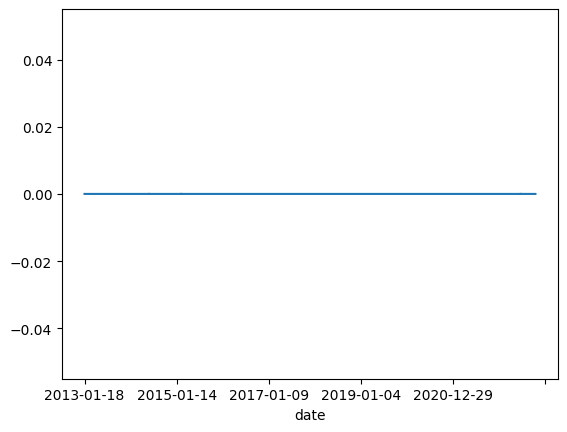

In [39]:
(df1 - df2).cp_location_norm.plot()

In [40]:
check_for_consistency_between_two_dataframes(df1, df2)

0.0
0.0
0.0
0.0
The two DataFrames are the same


In [27]:
pd.read_csv( "/Users/abuj/Documents/GitHub/CFT/datasets/META_FEATURES/CPD/A_temp_cpd.csv" ).cp_location_norm

0       0.689471
1       0.548039
2       0.834246
3       0.819757
4       0.917409
          ...   
2437    0.519940
2438    0.605042
2439    0.083087
2440    0.627954
2441    0.473023
Name: cp_location_norm, Length: 2442, dtype: float64